# Semi-gradient SARSA with SGD Regreessor

This notebook is an additional implmentation of `semi-gradient SARSA` using an stochastic gradient regressor instead of neural networks

## Setup

In [1]:
!pip install -qU \
    ipympl \
    ipywidgets \
    moviepy \
    scikit-learn

In [2]:
import itertools
import sys
from typing import *

import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np

State = Tuple[float, ...]

sys.path.append("../..")


def println(text: str):
    sys.stdout.write("\r" + text)

## Parameters

In [3]:
# featurizer
num_tilings = 8
tiling_size = 1024
# SARSA
num_episodes = 3000
max_ep_steps = 200
discount = 0.95
epsilon = 0.1

## Environment

We use [MountainCar-v0](https://gymnasium.farama.org/environments/classic_control/mountain_car/) as our testing environment

In [4]:
from itertools import product

# env
env = gym.make("MountainCar-v0")
obs = env.observation_space
boundaries = list(zip(obs.low, obs.high))


def run_until_random_success():
    done = 0
    ep = -1
    while True:
        ep += 1
        state, _ = env.reset()
        for t in itertools.count():
            a = np.random.choice(range(env.action_space.n))

            next_state, reward, terminated, truncated, _ = env.step(a)

            if terminated:
                print(f"ep:{ep} - steps:{t}")
                done += 1
                break

        if done > 5:
            break


def generate_states(skip_dims: Optional[List[int]] = None):
    # Generate X, Y coordinates
    ranges = []
    box = env.observation_space
    if box.bounded_above.any() and box.bounded_below.any():
        for i, (l, h) in enumerate(zip(box.low, box.high)):
            if skip_dims and i in skip_dims:
                continue
            step_size = (h - l) / num_tilings / 10
            ranges.append(np.arange(l, h, step_size))

    return ranges


state_ranges = generate_states()
states = list(product(*state_ranges))

## Featurizer

We use **tiling** to featurize a continous observation space

In [5]:
from itertools import product

from helpers.features.tile_coding import IHT, tiles

iht = IHT(tiling_size)


def tile_featurize(states: Union[State, List[State]]) -> np.array:
    def _feat(state):
        indices = tiles(
            iht,
            num_tilings,
            [num_tilings * s / (b[1] - b[0]) for s, b in zip(state, boundaries)],
        )
        # 1-hot encoding
        x = np.zeros(tiling_size)
        x[indices] = 1
        return x

    if isinstance(states, list):
        return np.array([_feat(s) for s in states])

    return _feat(states)


tile_featurize(states).shape

(6400, 1024)

## Value Function Aproximator

In [6]:
from sklearn.linear_model import SGDRegressor


class Estimator:
    """
    Value Function approximator.
    """

    def __init__(self):
        # We create a separate model for each action in the environment's
        # action space. Alternatively we could somehow encode the action
        # into the features, but this way it's easier to code up.
        self.models = []
        s, _ = env.reset()
        for _ in range(env.action_space.n):
            model = SGDRegressor(learning_rate="constant")
            # We need to call partial_fit once to initialize the model
            # or we get a NotFittedError when trying to make a prediction
            # This is quite hacky.
            model.partial_fit([tile_featurize(s)], [0])
            self.models.append(model)

    def __call__(self, s, a=None):
        """
        Makes value function predictions.

        Args:
            s: state to make a prediction for
            a: (Optional) action to make a prediction for

        Returns
            If an action a is given this returns a single number as the prediction.
            If no action is given this returns a vector or predictions for all actions
            in the environment where pred[i] is the prediction for action i.

        """
        features = tile_featurize(s)
        if not a:
            return np.array([m.predict([features])[0] for m in self.models])
        else:
            return self.models[a].predict([features])[0]

    def update(self, s, a, y):
        """
        Updates the estimator parameters for a given state and action towards
        the target y.
        """
        features = tile_featurize(s)
        self.models[a].partial_fit([features], [y])

## Plotting

In [7]:
ACTION_COLORS = [(1, 0, 0, 0.3), (0.3, 0.3, 0.3, 0.3), (0, 0, 1, 0.3)]


def plot_q_map(state_ranges, q):
    fig = plt.figure(figsize=(8, 6))
    x, y = state_ranges
    m_shape = (x.shape[0], y.shape[0])
    plt.imshow(
        q.argmax(axis=-1).reshape(m_shape),
    )
    loc = [l * 4 for l in range(m_shape[0] // 4)]
    plt.xticks(loc, [f"{x[l]:.2f}" for l in loc], rotation=45)
    plt.yticks(loc, [f"{y[l]:.2f}" for l in loc])


def plot_q_surface(title="Q-value function"):
    x, y = np.meshgrid(*state_ranges)

    # Max over actions as the State value
    q = np.array([Q(s) for s in states])
    z = q.max(axis=-1).reshape(x.shape)

    # Colorize the plot based on the chose action
    colors = np.array([ACTION_COLORS[i] for i in q.argmax(axis=-1)]).reshape(
        (*x.shape, 4)
    )

    # Plot
    fig = plt.figure(figsize=(6, 4))
    ax = fig.add_subplot(111, projection="3d")
    ax.set_title(title)
    ax.plot_surface(x, y, z, cmap="viridis", edgecolor="green", facecolors=colors)
    plt.show()

## Semi-gradient SARSA

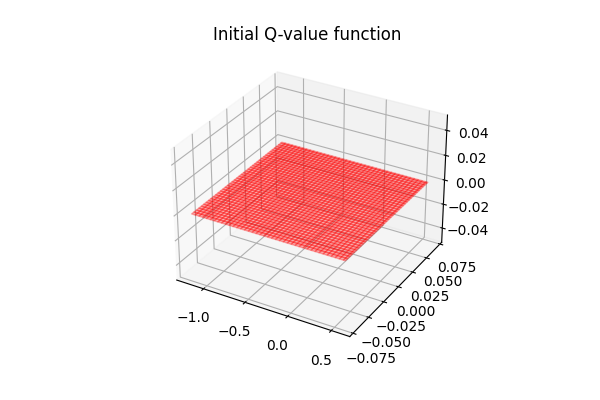

Start learning


  0%|          | 0/3000 [00:00<?, ?it/s]

EP:0 - Success! reward: -154.0

/home/ubuntu/code/scratch-RL/.venv/lib/python3.10/site-packages/gymnasium/utils/passive_env_checker.py:249: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


EP:2999 - Success! reward: -148.0

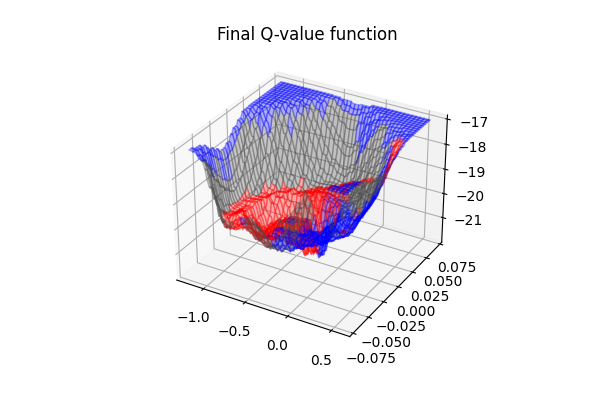

In [8]:
%matplotlib widget

import random

from tqdm.auto import tqdm


def policy(state: State) -> int:
    """Run the current policy. In this case e-greedy with constant epsilon

    Args:
        state (int): agent state
    """
    if random.random() < epsilon:
        return np.random.choice(range(env.action_space.n))

    return np.argmax(Q(state))


def observe(n_step_buffer: List[Tuple[Any, ...]]):
    n = len(n_step_buffer) - 1
    state, action, reward, _, _ = n_step_buffer[0]
    next_state, next_action, _, _, _ = n_step_buffer[-1]
    # Compute G_t
    # n-step SARSA update:
    # If n == 1 (i.e.: 1-step SARSA update), then:
    # td_target = reward + discount * Q(next_state)[next_action]
    g = (
        sum(discount**i * r for i, (_, _, r, _, _) in enumerate(n_step_buffer[:-1]))
        + discount**n * Q(next_state)[next_action]
    )
    Q.update(state, action, g)


def learn(n: int = 4) -> Dict[str, Any]:
    """Implements the On-policy TD Control algorithm 'n-step Semi Gradient SARSA'

    Args:
        num_episodes (int): max number of episodes
        max_ep_steps (int): max number of steps per episode
        discount (float): discount factor (gamma)
        epsilon (float): probability of taking a random action (epsilon-greedy)
        n (int): n-step return update target
    """
    print("Start learning")
    stats = {
        "ep_length": np.zeros(num_episodes),
        "ep_rewards": np.zeros(num_episodes),
        "ep_loss": np.zeros(num_episodes),
    }

    episode_iter = tqdm(range(num_episodes))
    for ep_i in episode_iter:
        episode_iter.set_description(f"Episode: {ep_i}")

        # Init S & chose A from S using policy derived from Q
        state, _ = env.reset()
        action = policy(state)

        n_step_buffer = []
        for t in range(max_ep_steps):
            # Take action A, observe S' and R
            next_state, reward, terminated, truncated, _ = env.step(action)

            if terminated or truncated:
                if terminated:
                    r = stats["ep_rewards"][ep_i] + reward
                    println(f"EP:{ep_i} - Success! reward: {r}")
                break

            # Chose A' from S' using policy derived from Q
            next_action = policy(next_state)

            if len(n_step_buffer) > n:
                # Let the agent observe and make an update to the Q-function
                observe(n_step_buffer)
                n_step_buffer = []
            else:
                n_step_buffer.append((state, action, reward, next_state, next_action))

            # Collect some stats
            stats["ep_length"][ep_i] = t
            stats["ep_rewards"][ep_i] += reward

            state = next_state
            action = next_action

    # Done!
    env.close()

    return stats


Q = Estimator()
plot_q_surface(title="Initial Q-value function")

# 1-step SARSA
learn(n=8)
plot_q_surface("Final Q-value function")

## Run

In [9]:
%matplotlib inline

import gnwrapper
from IPython import display

env = gym.make("MountainCar-v0", render_mode="rgb_array")

for ep_i in range(10):
    ep_reward = 0
    state, _ = env.reset()
    for t in range(max_ep_steps):
        action = policy(state)

        # Take action A, observe S' and R
        next_state, reward, terminated, truncated, _ = env.step(action)
        ep_reward += reward

        # # render
        # if t % 2 == 0:
        #     plt.imshow(env.render())
        #     display.display(plt.gcf())
        #     display.clear_output(wait=True)

        if terminated or truncated:
            print(f"Episode: {ep_i} -> Done! {t} steps. R:{ep_reward}")
            break

        state = next_state

ModuleNotFoundError: No module named 'gnwrapper'